In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from bs4 import BeautifulSoup

In [2]:
experiments = os.listdir('../data')

In [3]:
def extract_tripinfo(tripinfo, path):
    vid = tripinfo['id']
    vtype = tripinfo['vType']
    depart_time = float(tripinfo['depart'])
    depart_lane = tripinfo['departLane']
    depart_delay = float(tripinfo['departDelay'])
    arrival_time = float(tripinfo['arrival'])
    arrival_lane = tripinfo['arrivalLane']
    duration = float(tripinfo['duration'])
    route_length = float(tripinfo['routeLength'])
    waiting_time = float(tripinfo['waitingTime'])
    waiting_count = int(tripinfo['waitingCount'])
    time_loss = float(tripinfo['timeLoss'])
    speed_factor = float(tripinfo['speedFactor'])
    
    emissions = tripinfo.find('emissions')
    co_abs = float(emissions['CO_abs'])
    co2_abs = float(emissions['CO2_abs'])
    hc_abs = float(emissions['HC_abs'])
    pmx_abs = float(emissions['PMx_abs'])
    nox_abs = float(emissions['NOx_abs'])
    fuel_abs = float(emissions['fuel_abs'])
    
    return path, vid, vtype, depart_time, depart_lane, depart_delay, arrival_time, arrival_lane, duration, route_length, waiting_time, waiting_count, time_loss, speed_factor, co_abs, co2_abs, hc_abs, pmx_abs, nox_abs, fuel_abs


def extract_personinfo(personinfo, path):
    vid = personinfo['id']
    vtype = personinfo['type']
    
    walk = personinfo.find('walk')
    depart_time = float(walk['depart'])
    depart_lane = None
    depart_delay = None
    arrival_time = float(walk['arrival'])
    arrival_lane = None
    duration = float(walk['duration'])
    route_length = float(walk['routeLength'])
    waiting_time = None
    waiting_count = None
    time_loss = float(walk['timeLoss'])
    speed_factor = None
    
    co_abs = 0
    co2_abs = 0
    hc_abs = 0
    pmx_abs = 0
    nox_abs = 0
    fuel_abs = 0
    
    return path, vid, vtype, depart_time, depart_lane, depart_delay, arrival_time, arrival_lane, duration, route_length, waiting_time, waiting_count, time_loss, speed_factor, co_abs, co2_abs, hc_abs, pmx_abs, nox_abs, fuel_abs


def extract_tripinfos(path):
    def curry_extract_tripinfo(tripinfo):
        return extract_tripinfo(tripinfo, path)
    
    def curry_extract_personinfo(personinfo):
        return extract_personinfo(personinfo, path)
    
    with open('../data/{}/tripinfo.xml'.format(path)) as file:
        parsed = BeautifulSoup(file, 'xml')
        
        tripinfos = parsed.find_all('tripinfo')
        personinfos = parsed.find_all('personinfo')
        
        return itertools.chain(map(curry_extract_tripinfo, tripinfos), map(curry_extract_personinfo, personinfos))
    
trips = pd.DataFrame(tqdm(itertools.chain.from_iterable(map(extract_tripinfos, experiments))), columns=[
    'path', 'vid', 'vtype', 'depart_time', 'depart_lane', 'depart_delay', 
    'arrival_time', 'arrival_lane', 'duration', 'route_length', 
    'waiting_time', 'waiting_count', 'time_loss', 'speed_factor',
    'co_abs', 'co2_abs', 'hc_abs', 'pmx_abs', 'nox_abs', 'fuel_abs'
])

In [4]:
trips.head()

,path,vid,vtype,depart_time,depart_lane,depart_delay,arrival_time,arrival_lane,duration,route_length,waiting_time,waiting_count,time_loss,speed_factor,co_abs,co2_abs,hc_abs,pmx_abs,nox_abs,fuel_abs
0,simple_prediction_30_control_30_prob,east_west.0,DEFAULT_VEHTYPE,1.8,2i_0,0.0,65.15,1o_0,63.35,994.9,0.0,0.0,2.73,1.16,1774.723505,171718.255394,12.173807,2.950553,66.683458,73.814030
1,simple_prediction_30_control_30_prob,west_east.0,DEFAULT_VEHTYPE,0.3,1i_0,0.0,76.55,2o_0,76.25,994.9,0.0,0.0,1.97,0.95,1547.708824,149704.374148,10.463873,2.221850,56.862311,64.351662
2,simple_prediction_30_control_30_prob,west_east.1,DEFAULT_VEHTYPE,2.0,1i_0,1.6,78.10,2o_0,76.10,994.9,0.0,0.0,10.41,1.07,1921.198749,168013.957523,12.640089,2.680191,65.426877,72.222025
3,simple_prediction_30_control_30_prob,east_west.1,DEFAULT_VEHTYPE,3.2,2i_0,0.0,80.75,1o_0,77.55,994.9,0.0,0.0,1.93,0.93,1600.300136,151293.410874,10.722627,2.225804,57.482931,65.034767
4,simple_prediction_30_control_30_prob,east_west.2,DEFAULT_VEHTYPE,5.2,2i_0,0.0,82.30,1o_0,77.10,994.9,0.0,0.0,12.19,1.08,1978.101438,167249.640439,12.879985,2.690762,65.406238,71.893485


In [5]:
aarhus = trips[trips['path'].str.startswith('aarhus')]

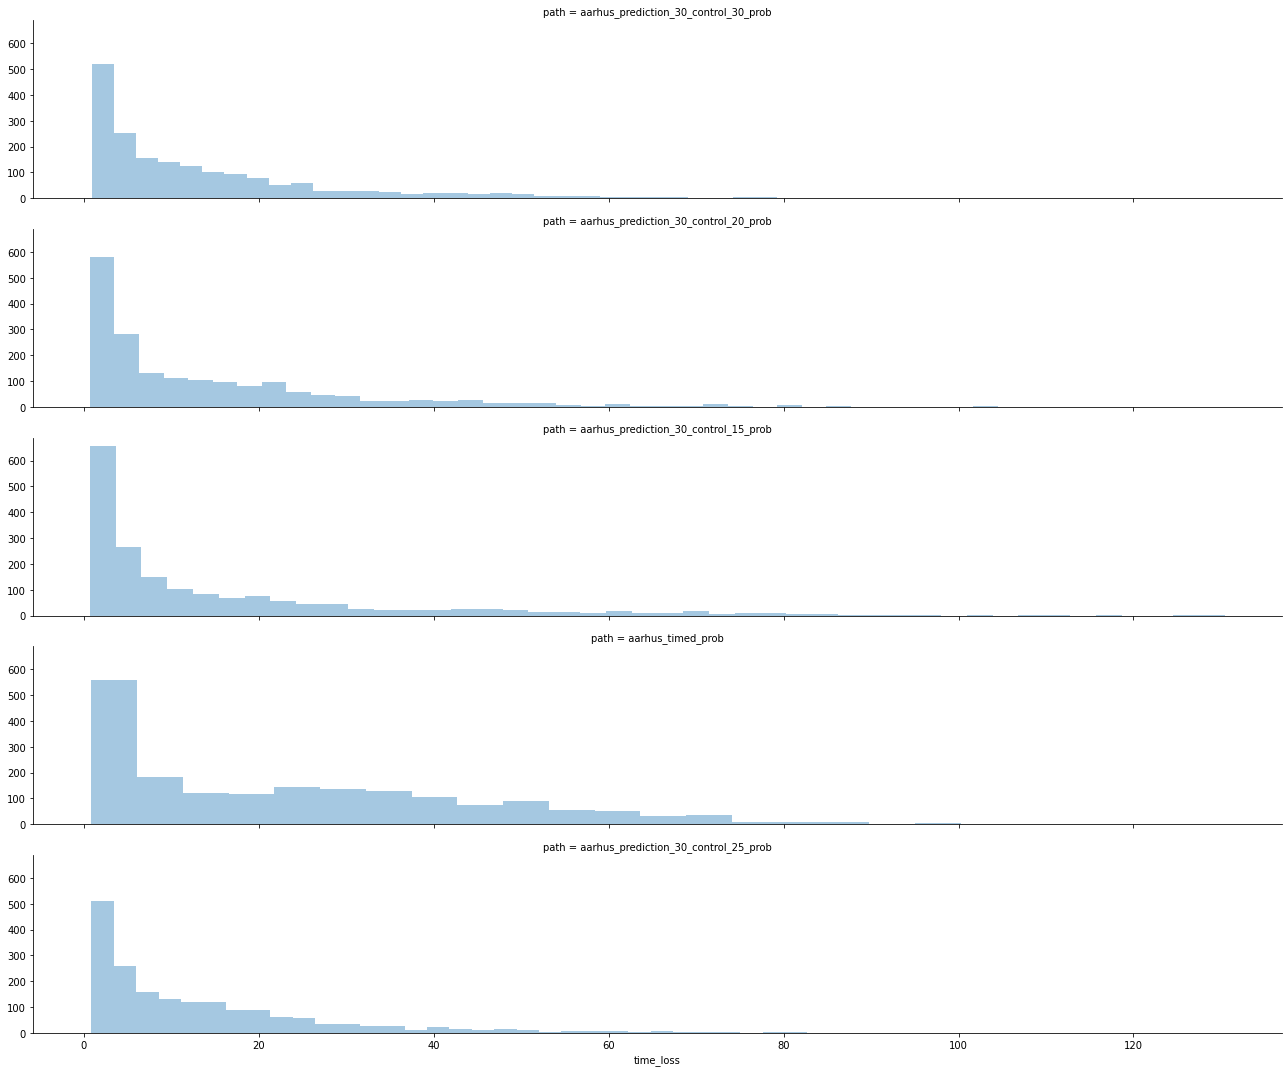

In [6]:
g = sns.FacetGrid(aarhus, row='path',
                  height=3, aspect=6)
g.map(sns.distplot, 'time_loss', kde=False);

In [7]:
aarhus_avg = aarhus[['path', 'time_loss']].groupby('path')['time_loss'].mean()
aarhus_avg

path
aarhus_prediction_30_control_15_prob    16.299533
aarhus_prediction_30_control_20_prob    14.417812
aarhus_prediction_30_control_25_prob    13.721585
aarhus_prediction_30_control_30_prob    13.925879
aarhus_timed_prob                       23.933714
Name: time_loss, dtype: float64

In [8]:
(aarhus_avg.max() - aarhus_avg) / aarhus_avg.max()

path
aarhus_prediction_30_control_15_prob    0.318972
aarhus_prediction_30_control_20_prob    0.397594
aarhus_prediction_30_control_25_prob    0.426684
aarhus_prediction_30_control_30_prob    0.418148
aarhus_timed_prob                       0.000000
Name: time_loss, dtype: float64

In [9]:
simple = trips[trips['path'].str.startswith('simple')]

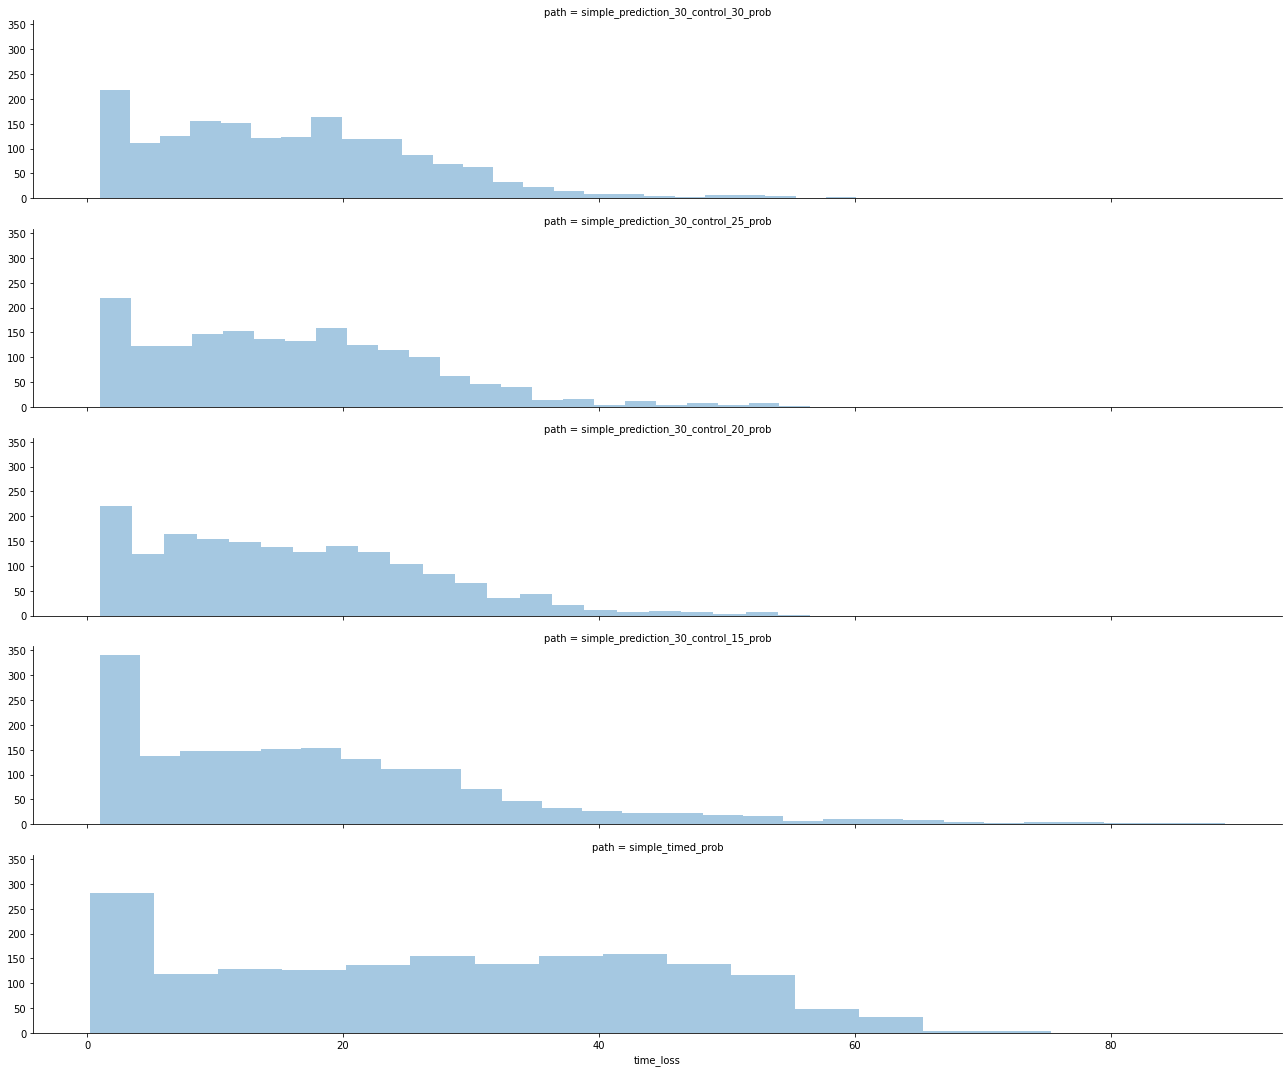

In [10]:
g = sns.FacetGrid(simple, row='path',
                  height=3, aspect=6)
g.map(sns.distplot, 'time_loss', kde=False);

In [11]:
simple_avg = simple[['path', 'time_loss']].groupby('path')['time_loss'].mean()
simple_avg

path
simple_prediction_30_control_15_prob    18.399473
simple_prediction_30_control_20_prob    16.091013
simple_prediction_30_control_25_prob    15.950040
simple_prediction_30_control_30_prob    15.961277
simple_timed_prob                       27.444374
Name: time_loss, dtype: float64

In [12]:
(simple_avg.max() - simple_avg) / simple_avg.max()

path
simple_prediction_30_control_15_prob    0.329572
simple_prediction_30_control_20_prob    0.413686
simple_prediction_30_control_25_prob    0.418823
simple_prediction_30_control_30_prob    0.418413
simple_timed_prob                       0.000000
Name: time_loss, dtype: float64

In [13]:
super_simple = trips[trips['path'].str.startswith('super_simple')]

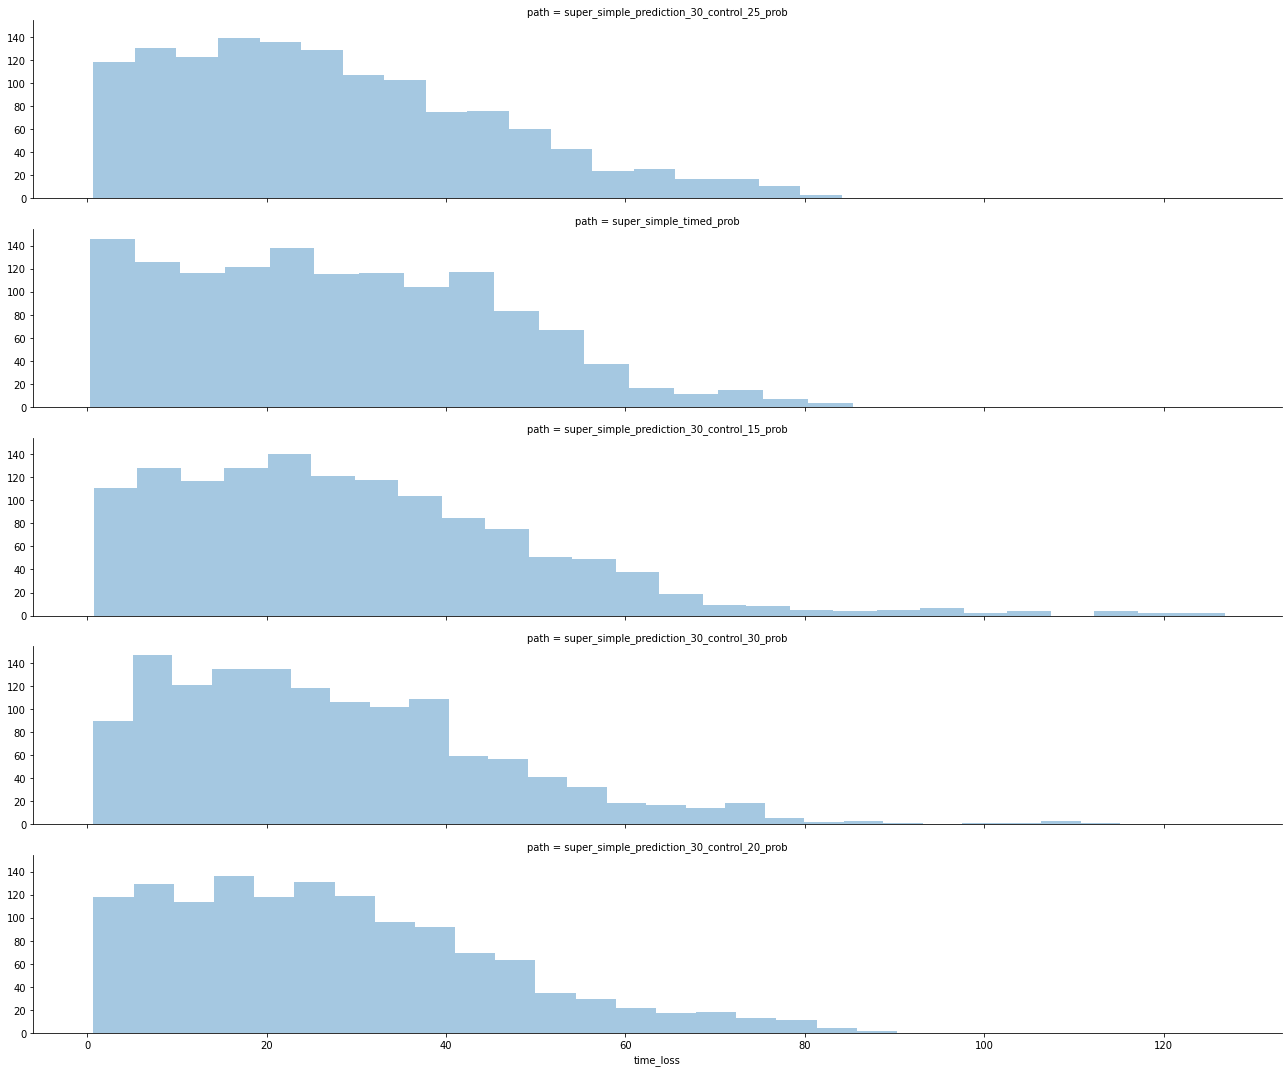

In [14]:
g = sns.FacetGrid(super_simple, row='path',
                  height=3, aspect=6)
g.map(sns.distplot, 'time_loss', kde=False);

In [15]:
super_simple_avg = super_simple[['path', 'time_loss']].groupby('path')['time_loss'].mean()
super_simple_avg

path
super_simple_prediction_30_control_15_prob    29.840621
super_simple_prediction_30_control_20_prob    27.338031
super_simple_prediction_30_control_25_prob    27.357163
super_simple_prediction_30_control_30_prob    27.209686
super_simple_timed_prob                       27.917063
Name: time_loss, dtype: float64

In [16]:
(super_simple_avg.max() - super_simple_avg) / super_simple_avg.max()

path
super_simple_prediction_30_control_15_prob    0.000000
super_simple_prediction_30_control_20_prob    0.083865
super_simple_prediction_30_control_25_prob    0.083224
super_simple_prediction_30_control_30_prob    0.088166
super_simple_timed_prob                       0.064461
Name: time_loss, dtype: float64

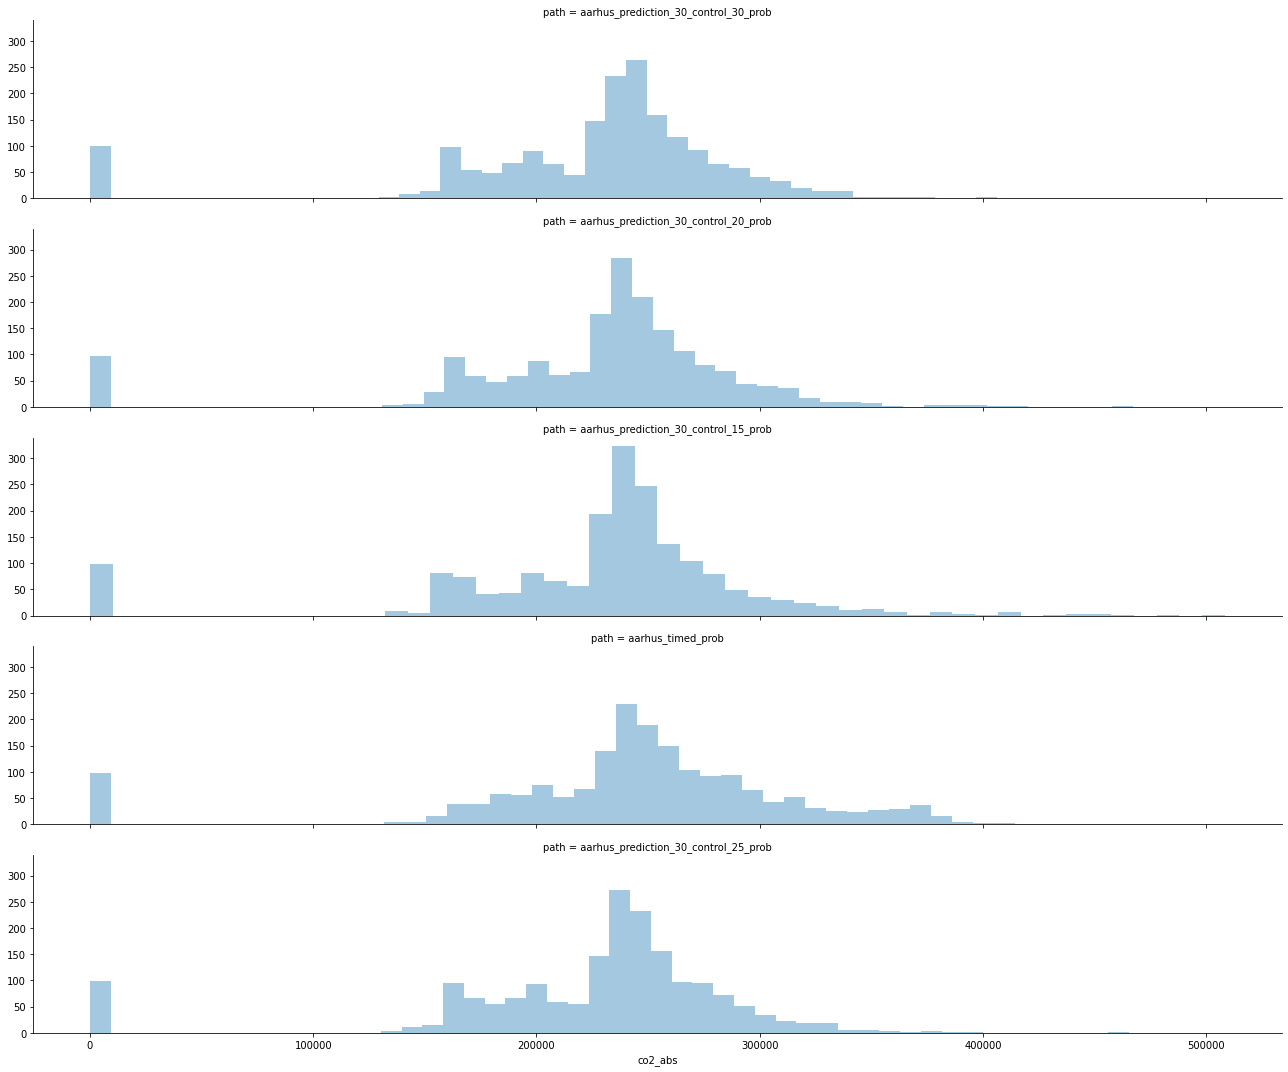

In [17]:
g = sns.FacetGrid(aarhus, row='path',
                  height=3, aspect=6)
g.map(sns.distplot, 'co2_abs', kde=False);

In [18]:
aarhus_co2_avg = aarhus[['path', 'co2_abs']].groupby('path')['co2_abs'].mean()
aarhus_co2_avg

path
aarhus_prediction_30_control_15_prob    228760.427594
aarhus_prediction_30_control_20_prob    225985.842805
aarhus_prediction_30_control_25_prob    224638.987920
aarhus_prediction_30_control_30_prob    224800.254279
aarhus_timed_prob                       242557.968656
Name: co2_abs, dtype: float64

In [19]:
(aarhus_co2_avg.max() - aarhus_co2_avg) / aarhus_co2_avg.max()

path
aarhus_prediction_30_control_15_prob    0.056883
aarhus_prediction_30_control_20_prob    0.068322
aarhus_prediction_30_control_25_prob    0.073875
aarhus_prediction_30_control_30_prob    0.073210
aarhus_timed_prob                       0.000000
Name: co2_abs, dtype: float64